# Revised version based on Federica's comments - performing the test for two months together

In [1]:
from __future__  import print_function, division
import pylab as pl
import pandas as pd
import numpy as np
import os
import zipfile
import io
import urllib2  #the lib that handles the url stuff
from scipy.stats import chi2_contingency


#import matplotlib
#import matplotlib.pyplot as plt
%pylab inline

if os.getenv ('PUI2016') is None:
    print ("Must set env variable PUI2016")
if os.getenv ('PUIDATA') is None:
    print ("Must set env variable PUI2016")

Populating the interactive namespace from numpy and matplotlib


In [2]:

os.getenv('PUIDATA')

'/home/cusp/ic1018/PUIdata'

In [3]:
os.getenv('PUI2016')

'/home/cusp/ic1018/PUI2016'

In [4]:
#filename = '{}-citibike-tripdata.zip'.format(201501)

#accesszipfile

In [5]:
### A function to download the data: simple bash commands can be run by preceding them with !
### but more complex command lines with variable arguments need to be build as strng and run with os.system
### this code cell does a lot of things: looks for existing files, download a file if none is there, unzips it, moves it.

def getCitiBikeCSV(datestring):
    print ("Downloading", datestring)
    ### First I will heck that it is not already there
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        if os.path.isfile(datestring + "-citibike-tripdata.csv"):
            # if in the current dir just move it
            if os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA")):
                print ("Error moving file!, Please check!")
        #otherwise start looking for the zip file
        else:
            if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip"):
                if not os.path.isfile(datestring + "-citibike-tripdata.zip"):
                    os.system("curl -O https://s3.amazonaws.com/tripdata/" + datestring + "-citibike-tripdata.zip")
                ###  To move it I use the os.system() functions to run bash commands with arguments
                os.system("mv " + datestring + "-citibike-tripdata.zip " + os.getenv("PUIDATA"))
            ### unzip the csv 
            os.system("unzip " + os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip")
            ## NOTE: old csv citibike data had a different name structure. 
            if '2014' in datestring:
                os.system("mv " + datestring[:4] + '-' +  datestring[4:] + 
                          "\ -\ Citi\ Bike\ trip\ data.csv " + datestring + "-citibike-tripdata.csv")
            os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA"))
    ### One final check:
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        print ("WARNING!!! something is wrong: the file is not there!")

    else:
        print ("file in place, you can continue")
    return pd.read_csv(os.getenv("PUIDATA") + "/" + datestring + '-citibike-tripdata.csv')    

In [6]:
#Taking two months
datestrings = ['201503','201504']
df = pd.concat([
     getCitiBikeCSV(datestring)
    for datestring in datestrings
]).reset_index(drop=True)


file in place, you can continue
file in place, you can continue


In [7]:
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,669,3/1/2015 0:00,3/1/2015 0:11,164,E 47 St & 2 Ave,40.753231,-73.970325,477,W 41 St & 8 Ave,40.756405,-73.990026,21409,Subscriber,1987.0,1
1,750,3/1/2015 0:01,3/1/2015 0:14,258,DeKalb Ave & Vanderbilt Ave,40.689407,-73.968855,436,Hancock St & Bedford Ave,40.682166,-73.953990,19397,Subscriber,1968.0,1
2,663,3/1/2015 0:01,3/1/2015 0:12,497,E 17 St & Broadway,40.737050,-73.990093,477,W 41 St & 8 Ave,40.756405,-73.990026,20998,Customer,NaN,0
3,480,3/1/2015 0:02,3/1/2015 0:10,470,W 20 St & 8 Ave,40.743453,-74.000040,491,E 24 St & Park Ave S,40.740964,-73.986022,21565,Subscriber,1983.0,1
4,1258,3/1/2015 0:02,3/1/2015 0:23,345,W 13 St & 6 Ave,40.736494,-73.997044,473,Rivington St & Chrystie St,40.721101,-73.991925,14693,Subscriber,1970.0,1


In [19]:
df.columns

Index([u'tripduration', u'starttime', u'stoptime', u'start station id',
       u'start station name', u'start station latitude',
       u'start station longitude', u'end station id', u'end station name',
       u'end station latitude', u'end station longitude', u'bikeid',
       u'usertype', u'birth year', u'gender'],
      dtype='object')

# IDEA:
## Customers are less likely to choose biking than subscribers for commuting.


# REVISED HYPOTHESIS (based on Federica's comment)

# NULL HYPOTHESIS:
## The ratio of subscribers biking on weekends over total number of subscribers biking in a week is _the same_ or _higher_  than the ratio of customers biking over weekends to total number of customers biking in a week


# _$H_0$_ : $\frac{Customer_{\mathrm{weekend}}}{Customer_{\mathrm{total (week + weekend)}}} <= \frac{Subscriber_{\mathrm{weekend}}}{Subs_{\mathrm{total (week + weekend)}}}$
# _$H_1$_ : $\frac{Customer_{\mathrm{weekend}}}{Customer_{\mathrm{total (week + weekend)}}} > \frac{Subscriber_{\mathrm{weekend}}}{Subscriber_{\mathrm{total (week + weekend)}}}$

or identically:

# _$H_0$_ : $\frac{Customer_{\mathrm{weekend}}}{Customer_{\mathrm{total (week + weekend)}}} - \frac{Subscriber_{\mathrm{weekend}}}{Subs_{\mathrm{total (week + weekend)}}} <= 0 $
# _$H_1$_ : $\frac{Customer_{\mathrm{weekend}}}{Customer_{\mathrm{total (week + weekend)}}} - \frac{Subscriber_{\mathrm{weekend}}}{Subscriber_{\mathrm{total (week + weekend)}}} > 0$
## I will use a significance level  $\alpha=0.05$




#### which means i want the probability of getting a result at least as significant as mine to be less then 5%

In [8]:
# Drop any missing values and storing the data into new dataframe 'data'
data = df.dropna(subset=['usertype', 'starttime']).copy()

# Use starttime as the date
data['date'] = pd.to_datetime(data['starttime'])

# Take away all the other columns except 'date' and 'usertype'
data.drop([
        col for col in data.columns 
        if col not in ['date', 'usertype']
], axis=1, inplace=True)

data.head()

,usertype,date
0,Subscriber,2015-03-01 00:00:00
1,Subscriber,2015-03-01 00:01:00
2,Customer,2015-03-01 00:01:00
3,Subscriber,2015-03-01 00:02:00
4,Subscriber,2015-03-01 00:02:00


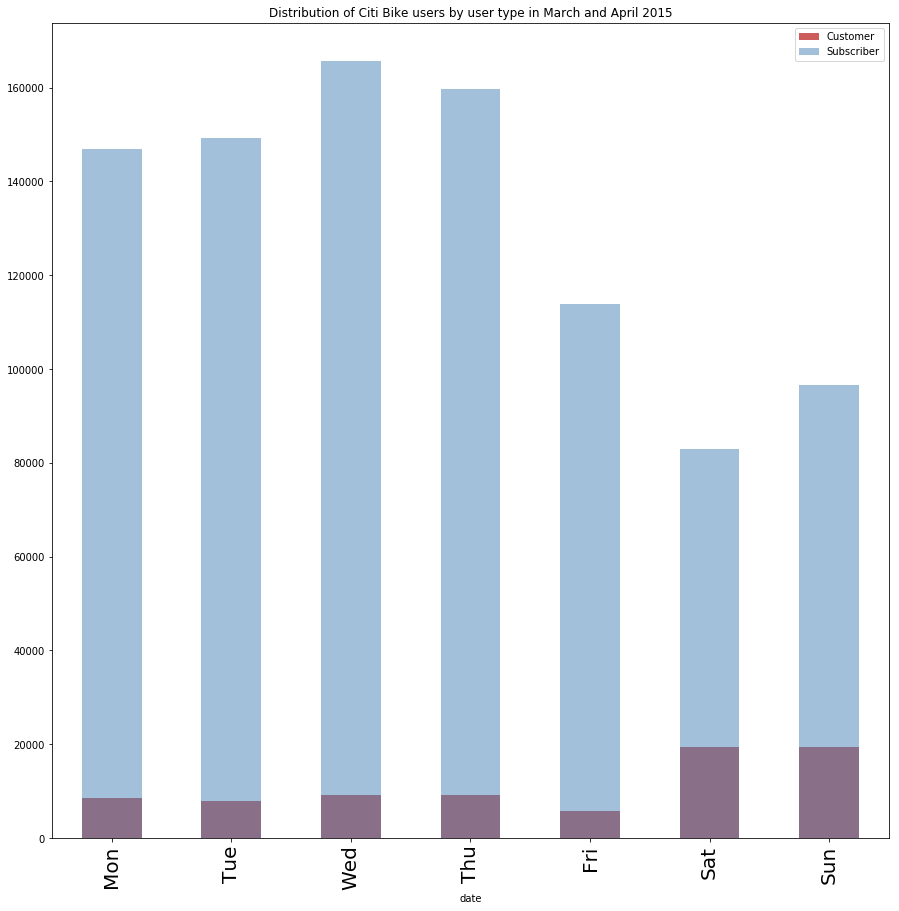

In [22]:
fig = pl.figure(figsize(15,15))

#instad of plotting with matplotlib i.e. plot() i use the plot method in pandas
norm_w = 1
((data['date'][data['usertype'] == 'Customer'].groupby([data['date'].dt.weekday]).count()) / norm_w).plot(kind="bar", 
                                                                                         color='IndianRed', 
                                                                                         label='Customer')

norm_m = 1
ax = ((data['date'][data['usertype'] == 'Subscriber'].groupby([data['date'].dt.weekday]).count()) / norm_m).plot(kind="bar", 
                                                                                              color='SteelBlue', 
                                                                                              alpha=0.5,
                                                                                              label='Subscriber')

tmp = ax.xaxis.set_ticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=20)
pl.title('Distribution of Citi Bike users by user type in March and April 2015')

pl.legend()

## Figure 1a: Distribution of Citibike bikers by usertype in March & April 2015, absolute counts

The following figure shows that there are more number of subscribers riding the bike than the customers over the course of an entire week. There is a sudden peak at Wednesday for subscribers, after which it starts to decrease. However for the customers,  there is increase in the number over the weekend.

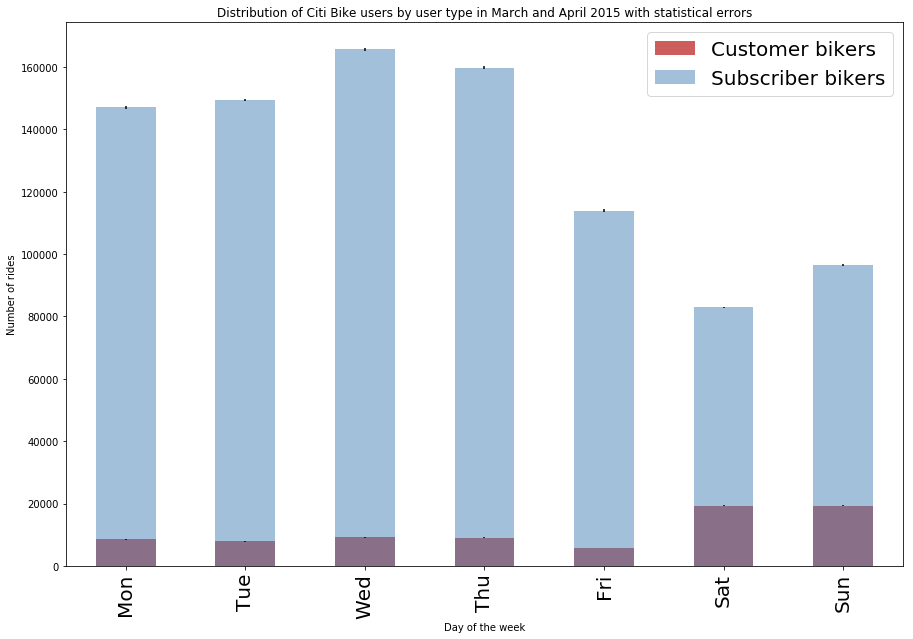

In [21]:
fig=pl.figure(figsize(15,10))

counts_c = data.date[data.usertype == 'Customer'].groupby([data.date.dt.weekday]).count()
norm_c = 1
error_c = np.sqrt(counts_c)
ax=((counts_c) / norm_c).plot(kind="bar",color='IndianRed',  yerr=[
            ((error_c) / norm_c, (error_c) / norm_c)], label='Customer bikers')


counts_s = data.date[data.usertype=="Subscriber"].groupby([data.date.dt.weekday]).count()
norm_s = 1
error_s=np.sqrt(counts_s)
((counts_s) / norm_s).plot(kind="bar", alpha=0.5, yerr=[((error_s) / norm_s, (error_s) / norm_s)], 
                           color='SteelBlue', label='Subscriber bikers')
ax.xaxis.set_ticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], fontsize=20)
ax.set_ylabel ("Number of rides")
ax.set_xlabel ("Day of the week")
pl.title('Distribution of Citi Bike users by user type in March and April 2015 with statistical errors')

pl.legend(['Customer bikers','Subscriber bikers'],fontsize=20)

## Figure 1b: Distribution of Citibike bikers by usertype in March & April 2015, absolute counts, with statistical errors

This plot shows the same information as Figure 1a, with statistical error bars added. The error bars look disproportionate because the overall magnitude of counts differs between the two user types.

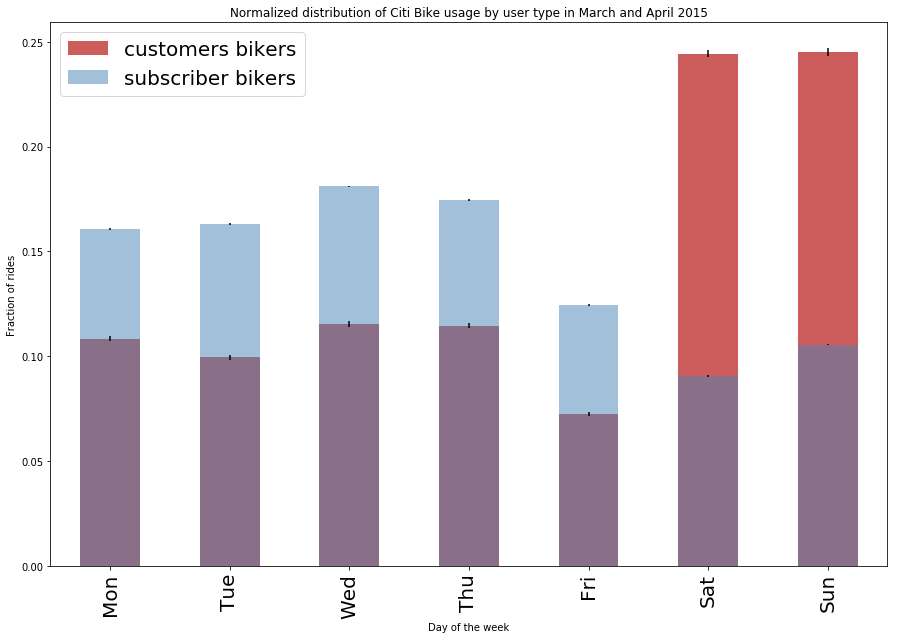

In [20]:
#difficult to compare absolute numbers, normalise the distribution of subscibers and customers 

fig = pl.figure(figsize(15,10))

norm_c = counts_c.sum()
error_c = np.sqrt(counts_c)
((counts_c) / norm_c).plot(kind="bar", color='IndianRed',  
                           yerr=[((error_c) / norm_c, (error_c) / norm_c)], 
                           label='customer bikers')

norm_s = counts_s.sum()
ax = ((counts_s) / norm_s).plot(kind="bar", alpha=0.5, 
                                yerr=[((error_s) / norm_s, (error_s) / norm_s)], 
                                color='SteelBlue', label='subscriber bikers')

ax.xaxis.set_ticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=20)
ax.set_ylabel ("Fraction of rides")
ax.set_xlabel ("Day of the week")
plt.title('Normalized distribution of Citi Bike usage by user type in March and April 2015')

pl.legend(['customers bikers','subscriber bikers'],fontsize=20)


# Figure 2: Normalized distribution of Citi Bike users by user type in March & April 2015

This plot shows the same information as Figures 1a and 1b, except the counts are normalized by their overall count.  This shows that proportionally, subscribers bike more at the beginning of the week whereas customers bike more during the weekend.


Subscribers: week:0.804, weekend:0.196, weekend error:0.001, weekend error:0.000
Customers: week:0.511, weekend:0.489, weekend error:0.003, weekend error:0.002


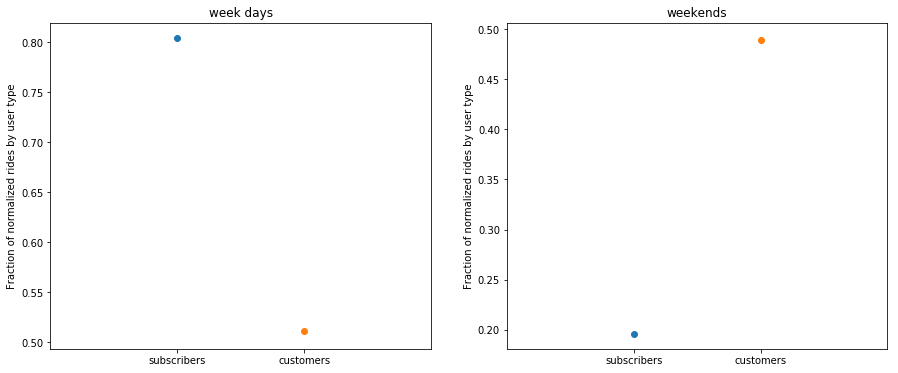

In [12]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

week_c = sum(counts_c[:-2]) * 1.0 / norm_c  #fraction of customers riding on week days
weekend_c = sum(counts_c[-2:]) * 1.0 / norm_c  #fraction of customers riding on weekends
eweek_c = np.sqrt(sum(counts_c[:-2])) / norm_c  #error on week_c (sum squared errors where errors are poisson)
eweekend_c = np.sqrt(sum(counts_c[-2:])) / norm_c #error on weekend_c

#same nomenclature as above for subscribers
week_s = sum(counts_s[:-2]) * 1. / norm_s
weekend_s = sum(counts_s[-2:]) * 1. / norm_s
eweek_s = np.sqrt(sum(counts_s[:-2])) / norm_s
eweekend_s = np.sqrt(sum(counts_s[-2:])) / norm_s

print("Subscribers: week:{0:.3f}, weekend:{1:.3f}, weekend error:{2:.3f}, weekend error:{3:.3f}"\
      .format(week_s, weekend_s, eweek_s, eweekend_s))
print("Customers: week:{0:.3f}, weekend:{1:.3f}, weekend error:{2:.3f}, weekend error:{3:.3f}"\
      .format(week_c, weekend_c, eweek_c, eweekend_c))

ax1.errorbar([0], [week_s], yerr=[eweek_s], fmt='o', label='subscribers')
ax1.errorbar([1], [week_c], yerr=[eweek_c], fmt='o', label='customers')
ax2.errorbar([0], [weekend_s], yerr=[eweekend_s], fmt='o', label='subscribers')
ax2.errorbar([1], [weekend_c], yerr=[eweekend_c], fmt='o', label='customers')
ax1.set_xlim(-1, 2)
ax2.set_xlim(-1, 2)
ax1.set_xticks([0, 1])
ax2.set_xticks([0, 1])
ax1.set_xticklabels(['subscribers', 'customers'])
ax2.set_xticklabels(['subscribers', 'customers'])
ax1.set_title("week days")
ax2.set_title("weekends")
ax1.set_ylabel("Fraction of normalized rides by user type")
ax2.set_ylabel("Fraction of normalized rides by user type");

# Figure 3: Fraction of Citibike bikers per user type in March and April 2015 for week days (left) and weekends (right)


This plot shows the comparison of normalized counts for user type over the week and the weekend respectively. This plot makes it clear that the distribution of subscribers lies towards the week whereas the distribution of customers lies towards the weekend.

In [13]:
#Checking the hypothesis
P0mP1 = (weekend_c / (week_c + weekend_c)) - (weekend_s / (week_s + weekend_s))
print ("difference between customers and subscribers weekend to total ratio: {:.4f}".format(P0mP1))
if P0mP1 <= 0:
    # we are done...
    print("In accordance with Null Hypothesis")
else:
    # morework to do
    print ("We must check the significance before we reject the Null Hypothesis")

difference between customers and subscribers weekend to total ratio: 0.2934
We must check the significance before we reject the Null Hypothesis


The ratio doesn't seem very high.

# Is this difference statistically significant?


In [14]:
contingency_table = pd.DataFrame([
    [weekend_c+ week_c, weekend_s + week_s],
    [weekend_c, weekend_s]
], columns=['Customers', 'Subscribers'], index=['Total', 'Weekend'])

print('chi-squared: {:.3f}, p-value: {}'.format(*chi2_contingency(contingency_table.values)[:2]))
contingency_table

chi-squared: 1.211, p-value: 0.271188832933


,Customers,Subscribers
Total,1.000000,1.000000
Weekend,0.489464,0.196071


The p-value returned by the chi-squared test is not below the significance threshold of 0.05, showing that the null hypothesis cannot be rejected.

# Test of Robustness - considering fri as weekend

Subscribers: week:0.679, weekend:0.321, weekend error:0.001, weekend error:0.001
Customers: week:0.438, weekend:0.562, weekend error:0.002, weekend error:0.003


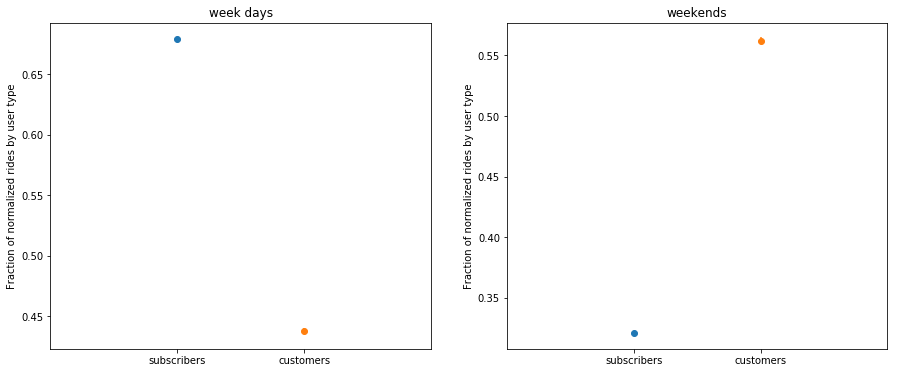

In [15]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

week_c = sum(counts_c[:-3]) * 1.0 / norm_c  #fraction of customers riding on week days
weekend_fri_c = sum(counts_c[-3:]) * 1.0 / norm_c  #fraction of customers riding on weekends
eweek_c = np.sqrt(sum(counts_c[:-3])) / norm_c  #error on week_c (sum squared errors where errors are poisson)
eweekend_fri_c = np.sqrt(sum(counts_c[-3:])) / norm_c #error on weekend_c

#same nomenclature as above for subscribers
week_s = sum(counts_s[:-3]) * 1. / norm_s
weekend_fri_s = sum(counts_s[-3:]) * 1. / norm_s
eweek_s = np.sqrt(sum(counts_s[:-3])) / norm_s
eweekend_fri_s = np.sqrt(sum(counts_s[-3:])) / norm_s

print("Subscribers: week:{0:.3f}, weekend:{1:.3f}, weekend error:{2:.3f}, weekend error:{3:.3f}"\
      .format(week_s, weekend_fri_s, eweek_s, eweekend_fri_s))
print("Customers: week:{0:.3f}, weekend:{1:.3f}, weekend error:{2:.3f}, weekend error:{3:.3f}"\
      .format(week_c, weekend_fri_c, eweek_c, eweekend_fri_c))

ax1.errorbar([0], [week_s], yerr=[eweek_s], fmt='o', label='subscribers')
ax1.errorbar([1], [week_c], yerr=[eweek_c], fmt='o', label='customers')
ax2.errorbar([0], [weekend_fri_s], yerr=[eweekend_fri_s], fmt='o', label='subscribers')
ax2.errorbar([1], [weekend_fri_c], yerr=[eweekend_fri_c], fmt='o', label='customers')
ax1.set_xlim(-1, 2)
ax2.set_xlim(-1, 2)
ax1.set_xticks([0, 1])
ax2.set_xticks([0, 1])
ax1.set_xticklabels(['subscribers', 'customers'])
ax2.set_xticklabels(['subscribers', 'customers'])
ax1.set_title("week days")
ax2.set_title("weekends")
ax1.set_ylabel("Fraction of normalized rides by user type")
ax2.set_ylabel("Fraction of normalized rides by user type");

This plot shows the comparison of normalized counts for user type over the week and the weekend (considering that friday is a weekend also) respectively. This plot makes it clear that the distribution of subscribers lies towards the week whereas the distribution of customers lies towards the weekend. The fraction values of normalized rides by user type has decreased for subscribers for weekdays and overall and increased for customers for weekend and overall, as compared to the fraction values of normalized rides by user type in Figure 4.

# Figure 4: Fraction of Citibike bikers per user type in March and April 2015 for week days (left) and weekends (right)

In [16]:
#Checking the hypothesis
P0mP1 = (weekend_fri_c / (week_c + weekend_fri_c)) - (weekend_fri_s / (week_s + weekend_fri_s))
print ("difference between customers and subscribers weekend to week ratio: {:.4f}".format(P0mP1))
if P0mP1 <= 0:
    # we are done...
    print("In accordance with Null Hypothesis")
else:
    # morework to do
    print ("We must check the significance before we reject the Null Hypothesis")

difference between customers and subscribers weekend to week ratio: 0.2415
We must check the significance before we reject the Null Hypothesis


Here the difference has decreased as compared to the previous case, when friday was not considered to be part of the weekend.

# Is this difference statistically significant?

In [17]:
contingency_table = pd.DataFrame([
    [weekend_fri_c+ week_c, weekend_fri_s + week_s],
    [weekend_fri_c, weekend_fri_s]
], columns=['Customers', 'Subscribers'], index=['Total', 'Weekend(including friday)'])

print('chi-squared: {:.3f}, p-value: {}'.format(*chi2_contingency(contingency_table.values)[:2]))
contingency_table

chi-squared: 1.139, p-value: 0.285776829619


,Customers,Subscribers
Total,1.000000,1.000000
Weekend(including friday),0.562152,0.320604


The p-value returned by the chi-squared test is not below the significance threshold of 0.05, showing that the null hypothesis cannot be rejected.